# Creating machinery to filter metadata

The purpose of this notebook is to achieve the steps that are outlined below as well as create a helpful tool to filter the metadata related to the earth data analytics (EDA) capstone project.

1. Read in the metadata csv 
2. Spatially project those metadata so we can do spatial filters 
3. Calculate a bounding box around the available NEON sites 
4. Download a basemap and make sure it has the same spatial projection as your data.

In [1]:
# Import required packages
import os

import pandas as pd
import earthpy as et
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box, Polygon
import json
import requests

# Set working directory
directory_path = os.path.join(et.io.HOME, "earth-analytics")
os.chdir(directory_path)

In [43]:
# Download map of the world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Restrict map to usa.
usa = world[world.name == "United States of America"]

# Create path to metadata
metadata_path = os.path.join(
    "capstone", "macrosystems", "Data", "NEON_Field_Site_Metadata_20220224.csv")

# Read in metadata
metadata_df = pd.read_csv(metadata_path)

# See what the data looks like
metadata_df

,field_domain_id,field_site_id,field_site_name,field_site_type,field_site_subtype,field_colocated_site,field_site_host,field_site_url,field_nonneon_research_allowed,field_access_details,...,field_usgs_geology_unit,field_megapit_soil_family,field_soil_subgroup,field_avg_number_of_green_days,field_avg_grean_increase_doy,field_avg_green_max_doy,field_avg_green_decrease_doy,field_avg_green_min_doy,field_phenocams,field_number_tower_levels
0,D16,ABBY,Abby Road NEON,Gradient Terrestrial,NaN,NaN,Washington Department of Natural Resources,https://www.dnr.wa.gov/,Limited,Reseachers should coordinate with the site man...,...,WAEOv1b;0,NaN,Andic Humudepts,190.0,110,165,205,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,5.0
1,D10,ARIK,Arikaree River NEON,Core Aquatic,Wadeable Stream,NaN,The Nature Conservancy,https://www.nature.org/en-us/get-involved/how-...,Yes,Reseachers should coordinate with the site man...,...,COTo;0|COQe;0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN
2,D03,BARC,Lake Barco NEON,Core Aquatic,Lake,OSBS,University of Florida Foundation,https://ordway-swisher.ufl.edu/ResearchUse.aspx,Yes,This area is a very active research community ...,...,FLPOc;0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN
3,D18,BARR,Utqiaġvik NEON,Gradient Terrestrial,NaN,NaN,Ukpeagvik Inupiat Corporation,http://www.north-slope.org/departments/plannin...,Yes,Reseachers should coordinate with the site man...,...,A003.BW002_114,NaN,Typic Histoturbels,45.0,175,195,210,220,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0
4,D01,BART,Bartlett Experimental Forest NEON,Gradient Terrestrial,NaN,NaN,"Northern Research Station, US Forest Service",https://www.nrs.fs.fed.us/ef/locations/nh/bart...,Yes,Bartlett Experimental Forest has very limited ...,...,NHJc1b;0,"Coarse-loamy, isotic, frigid. Aquic Haplorthods.",Aquic Haplorthods,180.0,120,170,220,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,D07,WALK,Walker Branch NEON,Core Aquatic,Wadeable Stream,ORNL,Department of Energy,https://www.ornl.gov/division/esd,Very Limited,There is currently no system in place to autho...,...,TNOnc;10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN
77,D13,WLOU,West St Louis Creek NEON,Gradient Aquatic,Wadeable Stream,NaN,US Forest Service,https://www.fs.usda.gov/wps/portal/fsinternet/...,Yes,Researchers should coordinate directly with th...,...,COXb;0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN
78,D09,WOOD,Chase Lake National Wildlife Refuge NEON,Core Terrestrial,NaN,PRPO,US Fish and Wildlife Service,https://www.fws.gov/refuge/chase_lake/,Yes,This site host welcomes and encourages additio...,...,NDQcrh;0,"Coarse, loamy, over-sandy or sandy, skeletal, ...",Typic Haplustolls,170.0,120,180,210,290,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0
79,D16,WREF,Wind River Experimental Forest NEON,Core Terrestrial,NaN,NaN,"Pacific Northwest Research Station, US Forest ...",https://www.fs.usda.gov/pnw/,Yes,Reseachers should coordinate with the site man...,...,WAQv;0,"Medial, amorphic, mesic. Typic Hapludands.",Typic Hapludands,175.0,115,165,210,290,[Tower top](https://phenocam.sr.unh.edu/webcam...,8.0


In [3]:
# Convert pandas dataframe to a geopandas dataframe
metadata_gdf = gpd.GeoDataFrame(metadata_df,
                    geometry=gpd.points_from_xy(metadata_df.field_longitude,
                                                metadata_df.field_latitude))

# Assign crs to metadata_gpd
metadata_assigned_crs = metadata_gdf.set_crs(epsg=4326)

# Create a bounding box for NEON sites
meta_bound_box = box(*metadata_assigned_crs.total_bounds)

# Print box bounds
print(meta_bound_box.bounds)

# Order of the box is: minx, miny, maxx, maxy
metadata_gdf

(-156.61936, 17.96955, -66.79868, 71.28241)


,field_domain_id,field_site_id,field_site_name,field_site_type,field_site_subtype,field_colocated_site,field_site_host,field_site_url,field_nonneon_research_allowed,field_access_details,...,field_megapit_soil_family,field_soil_subgroup,field_avg_number_of_green_days,field_avg_grean_increase_doy,field_avg_green_max_doy,field_avg_green_decrease_doy,field_avg_green_min_doy,field_phenocams,field_number_tower_levels,geometry
0,D16,ABBY,Abby Road NEON,Gradient Terrestrial,NaN,NaN,Washington Department of Natural Resources,https://www.dnr.wa.gov/,Limited,Reseachers should coordinate with the site man...,...,NaN,Andic Humudepts,190.0,110,165,205,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,5.0,POINT (-122.33032 45.76244)
1,D10,ARIK,Arikaree River NEON,Core Aquatic,Wadeable Stream,NaN,The Nature Conservancy,https://www.nature.org/en-us/get-involved/how-...,Yes,Reseachers should coordinate with the site man...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN,POINT (-102.44715 39.75821)
2,D03,BARC,Lake Barco NEON,Core Aquatic,Lake,OSBS,University of Florida Foundation,https://ordway-swisher.ufl.edu/ResearchUse.aspx,Yes,This area is a very active research community ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN,POINT (-82.00841 29.67598)
3,D18,BARR,Utqiaġvik NEON,Gradient Terrestrial,NaN,NaN,Ukpeagvik Inupiat Corporation,http://www.north-slope.org/departments/plannin...,Yes,Reseachers should coordinate with the site man...,...,NaN,Typic Histoturbels,45.0,175,195,210,220,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-156.61936 71.28241)
4,D01,BART,Bartlett Experimental Forest NEON,Gradient Terrestrial,NaN,NaN,"Northern Research Station, US Forest Service",https://www.nrs.fs.fed.us/ef/locations/nh/bart...,Yes,Bartlett Experimental Forest has very limited ...,...,"Coarse-loamy, isotic, frigid. Aquic Haplorthods.",Aquic Haplorthods,180.0,120,170,220,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,6.0,POINT (-71.28737 44.06389)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,D07,WALK,Walker Branch NEON,Core Aquatic,Wadeable Stream,ORNL,Department of Energy,https://www.ornl.gov/division/esd,Very Limited,There is currently no system in place to autho...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN,POINT (-84.27925 35.95738)
77,D13,WLOU,West St Louis Creek NEON,Gradient Aquatic,Wadeable Stream,NaN,US Forest Service,https://www.fs.usda.gov/wps/portal/fsinternet/...,Yes,Researchers should coordinate directly with th...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Land-water interface](https://phenocam.sr.unh...,NaN,POINT (-105.91540 39.89137)
78,D09,WOOD,Chase Lake National Wildlife Refuge NEON,Core Terrestrial,NaN,PRPO,US Fish and Wildlife Service,https://www.fws.gov/refuge/chase_lake/,Yes,This site host welcomes and encourages additio...,...,"Coarse, loamy, over-sandy or sandy, skeletal, ...",Typic Haplustolls,170.0,120,180,210,290,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-99.24133 47.12820)
79,D16,WREF,Wind River Experimental Forest NEON,Core Terrestrial,NaN,NaN,"Pacific Northwest Research Station, US Forest ...",https://www.fs.usda.gov/pnw/,Yes,Reseachers should coordinate with the site man...,...,"Medial, amorphic, mesic. Typic Hapludands.",Typic Hapludands,175.0,115,165,210,290,[Tower top](https://phenocam.sr.unh.edu/webcam...,8.0,POINT (-121.95191 45.82049)


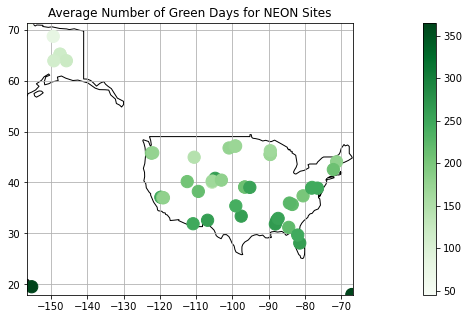

In [4]:
# Plot neon sites on map of usa 
# This plot is not plotting locations that have NaN values in the
# field_avg_number_of_green_days column of the dataframe
# Define figure space
fig, ax = plt.subplots(figsize=(25, 5))

# Plot map of usa
usa.plot(ax=ax, color="none", edgecolor="black")

# Add plot locations and color by average number of green days
metadata_assigned_crs.plot(ax=ax, column="field_avg_number_of_green_days", 
                           cmap="Greens", legend=True, markersize=150, zorder=2)
# Set title
ax.set(title="Average Number of Green Days for NEON Sites")

# Use meta_bound_box.bounds to resrict plot to NEON site locations
plt.xlim(meta_bound_box.bounds[0], meta_bound_box.bounds[2])
plt.ylim(meta_bound_box.bounds[1], meta_bound_box.bounds[3])

# Add grid
plt.grid(zorder=0)

In [5]:
# Filter metadata to only include terrestrial sites
core_terrestrial_sites = metadata_assigned_crs[(
    metadata_assigned_crs.field_site_type == "Core Terrestrial")]
gradient_terrestrial_sites = metadata_assigned_crs[(
    metadata_assigned_crs.field_site_type == "Gradient Terrestrial")]

# Combine geopandas dataframes
terrestrial_sites = core_terrestrial_sites.append(gradient_terrestrial_sites)

# Check out the resulting geopandas dataframe
terrestrial_sites

C:\Users\Rachel\AppData\Local\Temp\ipykernel_13956\2483527502.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  terrestrial_sites = core_terrestrial_sites.append(gradient_terrestrial_sites)


,field_domain_id,field_site_id,field_site_name,field_site_type,field_site_subtype,field_colocated_site,field_site_host,field_site_url,field_nonneon_research_allowed,field_access_details,...,field_megapit_soil_family,field_soil_subgroup,field_avg_number_of_green_days,field_avg_grean_increase_doy,field_avg_green_max_doy,field_avg_green_decrease_doy,field_avg_green_min_doy,field_phenocams,field_number_tower_levels,geometry
10,D19,BONA,Caribou-Poker Creeks Research Watershed NEON,Core Terrestrial,NaN,CARI,University of Alaska,https://www.uaf.edu/uaf/,Yes,NEON site is colocated with Boreal LTER. Pleas...,...,"Coarse-silty, mixed, superactive, subgelic. T...",Typic Histoturbels,115.0,135,180,210,250,[Tower top](https://phenocam.sr.unh.edu/webcam...,5.0,POINT (-147.50258 65.15401)
12,D11,CLBJ,Lyndon B. Johnson National Grassland NEON,Core Terrestrial,NaN,PRIN,US Forest Service,https://www.fs.usda.gov/detail/texas/about-for...,Very Limited,Researchers should coordinate directly with th...,...,NaN,Udic Paleustalfs,260.0,60|215,135|230,175|265,295|320,[Tower top](https://phenocam.sr.unh.edu/webcam...,5.0,POINT (-97.57000 33.40123)
14,D10,CPER,Central Plains Experimental Range NEON,Core Terrestrial,NaN,NaN,USDA-Agricultural Research Service,https://www.ars.usda.gov/plains-area/fort-coll...,Yes,Reseachers should coordinate with the site man...,...,"Fine, loamy, mixed, superactive, mesic. Aridi...",Aridic Argiustolls,260.0,90,165,210,350,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-104.74559 40.81554)
23,D04,GUAN,Guanica Forest NEON,Core Terrestrial,NaN,NaN,"State Forest, Dept. of Natural and Environment...",NaN,Limited,It is highly recommended that prospective rese...,...,"Coarse, loamy, carbonatic, isohyperthermic. Ty...",Typic Haplocalcids,365.0,NaN,NaN,NaN,NaN,[Tower top](https://phenocam.sr.unh.edu/webcam...,5.0,POINT (-66.86870 17.96955)
25,D01,HARV,Harvard Forest & Quabbin Watershed NEON,Core Terrestrial,NaN,HOPB,Harvard University|Massachusetts DCR Division ...,https://harvardforest.fas.harvard.edu/conducti...,Yes / Limited,Field site managed by Harvard University - ope...,...,"Coarse, loamy over sandy or sandy, skeletal, m...",Oxyaquic Dystrudepts,210.0,110,160,220,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,6.0,POINT (-72.17265 42.53691)
32,D06,KONZ,Konza Prairie Biological Station NEON,Core Terrestrial,NaN,NaN,"The Nature Conservancy, Kansas State University",https://kpbs.konza.k-state.edu/scientist-infor...,Yes,The Nature Conservancy and Konza Prairie Biolo...,...,"Fine, smectitic, mesic. Pachic Udertic Argiust...",Pachic Udertic Argiustolls,210.0,90,160,210,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-96.56307 39.10077)
44,D13,NIWO,Niwot Ridge NEON,Core Terrestrial,NaN,COMO,"US Forest Service, University of Colorado-Boulder",NaN,Yes,Reseachers should coordinate with the site man...,...,"Coarse, loamy, mixed, superactive. Typic Haplo...",Typic Haplocryolls,130.0,140,190,220,270,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-105.58237 40.05425)
48,D15,ONAQ,Onaqui NEON,Core Terrestrial,NaN,NaN,Bureau of Land Management,https://www.blm.gov/office/salt-lake-field-office,Limited,Reseachers should coordinate with the site man...,...,"Fine, loamy, mixed, superactive, mesic. Xeric ...",Xeric Haplocalcids,205.0,75,130,170,280,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-112.45245 40.17760)
49,D07,ORNL,Oak Ridge NEON,Core Terrestrial,NaN,WALK,Department of Energy,https://www.ornl.gov/division/esd,Very Limited,There is currently no system in place to autho...,...,"Fine, kaolinitic, thermic. Typic Paleudults.",Typic Paleudults,225.0,90,140,210,315,[Tower top](https://phenocam.sr.unh.edu/webcam...,6.0,POINT (-84.28259 35.96413)
50,D03,OSBS,Ordway-Swisher Biological Station NEON,Core Terrestrial,NaN,BARC|SUGG,University of Florida Foundation,https://ordway-swisher.ufl.edu/ResearchUse.aspx,Yes,This area is a very active research community ...,...,NaN,Typic Quartzi

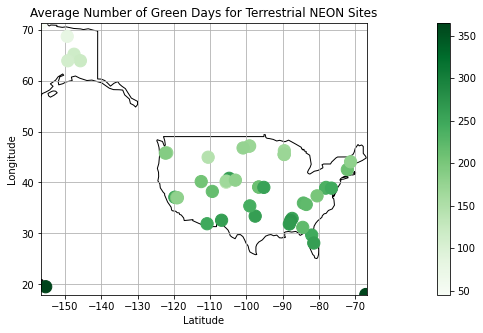

In [6]:
# Plot filtered data
# Define figure space
fig, ax = plt.subplots(figsize=(25, 5))

# Plot map of usa
usa.plot(ax=ax, color="none", edgecolor="black")

# Add plot locations and color by average number of green days
terrestrial_sites.plot(ax=ax, column="field_avg_number_of_green_days", 
                           cmap="Greens", legend=True, markersize=150, zorder=2)
# Set title
ax.set(xlabel="Latitude", 
       ylabel="Longitude", 
       title="Average Number of Green Days for Terrestrial NEON Sites")

# Use meta_bound_box.bounds to resrict plot to NEON site locations
plt.xlim(meta_bound_box.bounds[0], meta_bound_box.bounds[2])
plt.ylim(meta_bound_box.bounds[1], meta_bound_box.bounds[3])

# Add grid
plt.grid(zorder=0)

In [7]:
# Filter your data with a bounding box to only include sites in the “west” using the cx method
# Create a box with box(minx, miny, maxx, maxy)
west_box = box(-130, 25, -100, 50)

# Filter
west_terr_sites = terrestrial_sites.cx[west_box.bounds[0]:west_box.bounds[2], 
                                       west_box.bounds[1]:west_box.bounds[3]]
# Check it out
west_terr_sites

,field_domain_id,field_site_id,field_site_name,field_site_type,field_site_subtype,field_colocated_site,field_site_host,field_site_url,field_nonneon_research_allowed,field_access_details,...,field_megapit_soil_family,field_soil_subgroup,field_avg_number_of_green_days,field_avg_grean_increase_doy,field_avg_green_max_doy,field_avg_green_decrease_doy,field_avg_green_min_doy,field_phenocams,field_number_tower_levels,geometry
14,D10,CPER,Central Plains Experimental Range NEON,Core Terrestrial,NaN,NaN,USDA-Agricultural Research Service,https://www.ars.usda.gov/plains-area/fort-coll...,Yes,Reseachers should coordinate with the site man...,...,"Fine, loamy, mixed, superactive, mesic. Aridi...",Aridic Argiustolls,260.0,90,165,210,350,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-104.74559 40.81554)
44,D13,NIWO,Niwot Ridge NEON,Core Terrestrial,NaN,COMO,"US Forest Service, University of Colorado-Boulder",NaN,Yes,Reseachers should coordinate with the site man...,...,"Coarse, loamy, mixed, superactive. Typic Haplo...",Typic Haplocryolls,130.0,140,190,220,270,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-105.58237 40.05425)
48,D15,ONAQ,Onaqui NEON,Core Terrestrial,NaN,NaN,Bureau of Land Management,https://www.blm.gov/office/salt-lake-field-office,Limited,Reseachers should coordinate with the site man...,...,"Fine, loamy, mixed, superactive, mesic. Xeric ...",Xeric Haplocalcids,205.0,75,130,170,280,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-112.45245 40.17760)
60,D17,SJER,San Joaquin Experimental Range NEON,Core Terrestrial,NaN,NaN,US Forest Service,https://www.fs.fed.us/psw/ef/san_joaquin/,Yes,Researchers should coordinate directly with th...,...,NaN,Psammentic Haploxerolls,250.0,270,65,95,155,[Tower top](https://phenocam.sr.unh.edu/webcam...,6.0,POINT (-119.73228 37.10878)
62,D14,SRER,Santa Rita Experimental Range NEON,Core Terrestrial,NaN,NaN,University of Arizona,https://taac.arizona.edu/sites/taac.arizona.ed...,Yes,SRER encourages research activities that do no...,...,NaN,Typic Torrifluvents,247.0,87|186,139|215,189|259,219|334,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-110.83549 31.91068)
79,D16,WREF,Wind River Experimental Forest NEON,Core Terrestrial,NaN,NaN,"Pacific Northwest Research Station, US Forest ...",https://www.fs.usda.gov/pnw/,Yes,Reseachers should coordinate with the site man...,...,"Medial, amorphic, mesic. Typic Hapludands.",Typic Hapludands,175.0,115,165,210,290,[Tower top](https://phenocam.sr.unh.edu/webcam...,8.0,POINT (-121.95191 45.82049)
80,D12,YELL,Yellowstone National Park NEON,Core Terrestrial,NaN,BLDE|YELL,National Park Service,https://irma.nps.gov/rprs/,Limited,The National Park Service is open to additiona...,...,NaN,Pachic Argiustolls,144.0,125,169,193,269,[Tower top](https://phenocam.sr.unh.edu/webcam...,5.0,POINT (-110.53914 44.95348)
0,D16,ABBY,Abby Road NEON,Gradient Terrestrial,NaN,NaN,Washington Department of Natural Resources,https://www.dnr.wa.gov/,Limited,Reseachers should coordinate with the site man...,...,NaN,Andic Humudepts,190.0,110,165,205,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,5.0,POINT (-122.33032 45.76244)
29,D14,JORN,Jornada Experimental Range NEON,Gradient Terrestrial,NaN,NaN,USDA-Agricultural Research Service,https://jornada.nmsu.edu/,Yes,JORN encourages research activities that do no...,...,"Coarse, loamy, mixed, superactive, thermicc. T...",Typic Petrocalcids,260.0,80,185,245,340,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-106.84254 32.59069)
43,D13,MOAB,Moab NEON,Gradient Terrestrial,NaN,NaN,Bureau of Land Management,https://www.blm.gov/office/moab-field-office,Yes,Reseachers should coordinate with the site man...,...,"Coarse, loamy, mixed, superactive, mesic. Usti...",Ustic Haplocalcids,215.0,85,165,225,300,[Tower top](https://phenocam.sr.unh.edu/webcam...,4.0,POINT (-109.38827 38.24828)


(25.0, 50.0)

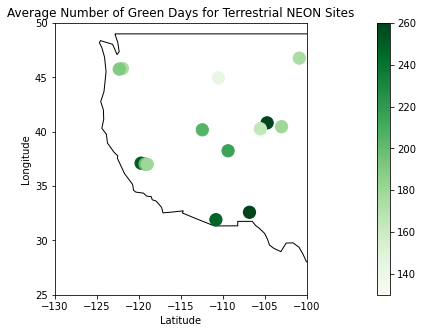

In [8]:
# Plot new dataframe to make sure the filter worked properly
# Define figure space
fig, ax = plt.subplots(figsize=(25, 5))

# Plot map of usa
usa.plot(ax=ax, color="none", edgecolor="black")

# Add plot locations and color by average number of green days
west_terr_sites.plot(ax=ax, column="field_avg_number_of_green_days", 
                           cmap="Greens", legend=True, markersize=150, zorder=2)
# Set title
ax.set(xlabel="Latitude", ylabel="Longitude", title="Average Number of Green Days for Terrestrial NEON Sites")

# Use west_box.bounds to resrict plot to NEON site locations to west
plt.xlim(west_box.bounds[0], west_box.bounds[2])
plt.ylim(west_box.bounds[1], west_box.bounds[3])

In [9]:
# Filter the western NEON sites to only include sites with Evergreen trees present
evergreen_sites = west_terr_sites[(
    west_terr_sites["field_dominant_nlcd_classes"].str.contains("Evergreen Forest"))]

# Check out the dataframe
type(evergreen_sites.field_site_type)

pandas.core.series.Series

(25.0, 50.0)

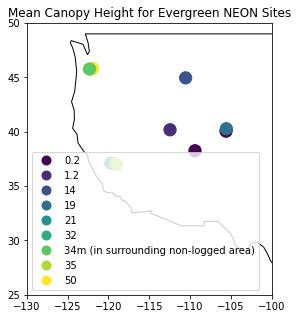

In [10]:
# Plot your Evergreen filter to confirm that your filter worked properly
# Define figure space
fig, ax = plt.subplots(figsize=(25, 5))

# Plot map of usa
usa.plot(ax=ax, color="none", edgecolor="black")

# Add plot locations and color by average number of green days
evergreen_sites.plot(ax=ax, column="field_mean_canopy_height_m", cmap="viridis", legend=True, markersize=150, zorder=2)

# Set title
ax.set(title="Mean Canopy Height for Evergreen NEON Sites")

# Use west_box.bounds to resrict plot to NEON site locations to west
plt.xlim(west_box.bounds[0], west_box.bounds[2])
plt.ylim(west_box.bounds[1], west_box.bounds[3])

In [11]:
# Create a list of evergreen site ids (could be used in a loop for later processing)
evergreen_site_ids = evergreen_sites["field_site_id"].tolist()

# Check out list to make sure it worked
sorted(evergreen_site_ids)

['ABBY',
 'MOAB',
 'NIWO',
 'ONAQ',
 'RMNP',
 'SJER',
 'SOAP',
 'TEAK',
 'WREF',
 'YELL']

In [76]:
# Create function that will do everything above and spit out a list of site ids
def get_site_ids(data_path, bounds, column1, column_info1, column2, column_info2):
    """Open NEON metadata file, turn it into a geopandas dataframe, and filter 
    the dataframe to only contain sites within a provided location.

    Parameters
    -----------
    data_path: string 
        A path to the csv to be opened.
    bounds: tuple
        A tuple with the order of minx, miny, maxx, maxy
    column1: pandas.Series
        A column within the dataframe that will be used to filter sites
    column_info1: string
        A string that specifies what information within column 1 you want to 
        use for filtering
    column2: pandas.Series
        A column within the dataframe that will be used to filter sites
    column_info2: string
        A string that specifies what information within column 2 you want to 
        use for filtering
     

    Returns
    -----------
    id_list : list
        A list of site ids

    """
    
    if os.path.basename(os.path.normpath(metadata_path)) == "NEON_Field_Site_Metadata_20220224.csv":

        # Open csv file
        metadata_df = pd.read_csv(data_path)
        
    else:
        print("Set your directory path to NEON_Field_Site_Metadata_20220224.csv before continuing.")

    # Convert pandas dataframe to a geopandas dataframe
    metadata_gpd = gpd.GeoDataFrame(metadata_df,
                                geometry=gpd.points_from_xy(metadata_df.field_longitude,
                                                            metadata_df.field_latitude))

    # Assign crs to metadata_gpd
    metadata_assigned_crs = metadata_gpd.set_crs(epsg=4326)
    

    # Filter your data with a box to only using the cx method
    filter_box = box(bounds[0], bounds[1], bounds[2], bounds[3])

    # Filter
    spatially_filtered_sites = metadata_assigned_crs.cx[filter_box.bounds[0]:filter_box.bounds[2], 
                                       filter_box.bounds[1]:filter_box.bounds[3]]

    if column1 in spatially_filtered_sites:
    
        # Filter by column1
        column1_gdf = spatially_filtered_sites[(
        spatially_filtered_sites[column1].str.contains(column_info1))]
    
    else:
        print("Oops, looks like the column you selected isn't in the dataframe.")
    
    if column2 in spatially_filtered_sites:
    
        # Filter by column2
        column2_gdf = column1_gdf[(
        column1_gdf[column2].str.contains(column_info2))]
    
    else:
        print("Oops, looks like the column you selected isn't in the dataframe.")
    
    # Create a list of site ids (could be used in a loop for later processing)
    site_ids = column2_gdf["field_site_id"].tolist()

    return site_ids

In [77]:
# Test function
ids = get_site_ids(metadata_path, (-130, 25, -100, 50), 
                   "field_site_type", "Terrestrial", 
                   "field_dominant_nlcd_classes", "Evergreen Forest")
ids

['ABBY',
 'MOAB',
 'NIWO',
 'ONAQ',
 'RMNP',
 'SJER',
 'SOAP',
 'TEAK',
 'WREF',
 'YELL']

In [14]:
# Create dataframe from pandas dataframe for use in project pitch
plot_df = metadata_df[["field_site_id", "field_site_name", "field_site_type", 
                       "field_avg_number_of_green_days", "field_latitude", 
                       "field_longitude"]].copy()
plot_df

,field_site_id,field_site_name,field_site_type,field_avg_number_of_green_days,field_latitude,field_longitude
0,ABBY,Abby Road NEON,Gradient Terrestrial,190.0,45.762439,-122.330320
1,ARIK,Arikaree River NEON,Core Aquatic,NaN,39.758206,-102.447150
2,BARC,Lake Barco NEON,Core Aquatic,NaN,29.675982,-82.008414
3,BARR,Utqiaġvik NEON,Gradient Terrestrial,45.0,71.282410,-156.619360
4,BART,Bartlett Experimental Forest NEON,Gradient Terrestrial,180.0,44.063889,-71.287375
...,...,...,...,...,...,...
76,WALK,Walker Branch NEON,Core Aquatic,NaN,35.957378,-84.279251
77,WLOU,West St Louis Creek NEON,Gradient Aquatic,NaN,39.891366,-105.915400
78,WOOD,Chase Lake National Wildlife Refuge NEON,Core Terrestrial,170.0,47.128200,-99.241334
79,WREF,Wind River Experimental Forest NEON,Core Terrestrial,175.0,45.820490,-121.951910


# Learn how to use an API

Select one of the sitecodes from the filtered metadataset above and enter it below. Follow the tutorial offered by NEON to explore the data structure and organizational scheme for neon api data.

https://www.neonscience.org/resources/learning-hub/tutorials/neon-api-01-introduction-requests

In [15]:
#Every request begins with the server's URL
SERVER = "http://data.neonscience.org/api/v0/"

#Site Code
SITECODE = "NIWO"

#Make request, using the sites/ endpoint
site_request = requests.get(SERVER+"sites/"+SITECODE)

#Convert to Python JSON object
site_json = site_request.json()

# Check it out
site_json

{'data': {'siteCode': 'NIWO',
  'siteName': 'Niwot Ridge NEON',
  'siteDescription': 'Niwot Ridge NEON',
  'siteType': 'CORE',
  'siteLatitude': 40.05425,
  'siteLongitude': -105.58237,
  'stateCode': 'CO',
  'stateName': 'Colorado',
  'domainCode': 'D13',
  'domainName': 'Southern Rockies and Colorado Plateau',
  'deimsId': 'https://deims.org/bd3322ed-0ae8-4da5-beb5-1bd5c9205fa1',
  'releases': [{'release': 'RELEASE-2021',
    'generationDate': '2021-01-23T02:30:02Z',
    'url': 'https://data.neonscience.org/api/v0/releases/RELEASE-2021'},
   {'release': 'RELEASE-2022',
    'generationDate': '2022-01-20T17:39:46Z',
    'url': 'https://data.neonscience.org/api/v0/releases/RELEASE-2022'}],
  'dataProducts': [{'dataProductCode': 'DP1.00001.001',
    'dataProductTitle': '2D wind speed and direction',
    'availableMonths': ['2017-07',
     '2017-08',
     '2017-09',
     '2017-10',
     '2017-11',
     '2017-12',
     '2018-01',
     '2018-02',
     '2018-03',
     '2018-04',
     '2018-0

In [16]:
# Use the 'keys' method to view the component of the uppermost json dictionary
site_json.keys()

dict_keys(['data'])

In [17]:
# Access the 'data' component, and use the 'keys' method to view to componenets of the json data dictionary
site_json['data'].keys()

dict_keys(['siteCode', 'siteName', 'siteDescription', 'siteType', 'siteLatitude', 'siteLongitude', 'stateCode', 'stateName', 'domainCode', 'domainName', 'deimsId', 'releases', 'dataProducts'])

In [18]:
# View the first data product dictionary
site_json['data']['dataProducts'][0]

{'dataProductCode': 'DP1.00001.001',
 'dataProductTitle': '2D wind speed and direction',
 'availableMonths': ['2017-07',
  '2017-08',
  '2017-09',
  '2017-10',
  '2017-11',
  '2017-12',
  '2018-01',
  '2018-02',
  '2018-03',
  '2018-04',
  '2018-05',
  '2018-06',
  '2018-07',
  '2018-08',
  '2018-09',
  '2018-10',
  '2018-11',
  '2018-12',
  '2019-01',
  '2019-02',
  '2019-03',
  '2019-04',
  '2019-05',
  '2019-06',
  '2019-07',
  '2019-08',
  '2019-09',
  '2019-10',
  '2019-11',
  '2019-12',
  '2020-01',
  '2020-02',
  '2020-03',
  '2020-04',
  '2020-05',
  '2020-06',
  '2020-07',
  '2020-08',
  '2020-09',
  '2020-10',
  '2020-11',
  '2020-12',
  '2021-01',
  '2021-02',
  '2021-03',
  '2021-04',
  '2021-05',
  '2021-06',
  '2021-07',
  '2021-08',
  '2021-09',
  '2021-10',
  '2021-11',
  '2021-12',
  '2022-01',
  '2022-02',
  '2022-03',
  '2022-04'],
 'availableDataUrls': ['https://data.neonscience.org/api/v0/data/DP1.00001.001/NIWO/2017-07',
  'https://data.neonscience.org/api/v0/data

In [19]:
# View product code and name for every available data product
for product in site_json['data']['dataProducts']:
    print(product['dataProductCode'],product['dataProductTitle'])

DP1.00001.001 2D wind speed and direction
DP1.00002.001 Single aspirated air temperature
DP1.00003.001 Triple aspirated air temperature
DP1.00004.001 Barometric pressure
DP1.00005.001 IR biological temperature
DP1.00006.001 Precipitation
DP1.00013.001 Wet deposition chemical analysis
DP1.00014.001 Shortwave radiation (direct and diffuse pyranometer)
DP1.00017.001 Dust and particulate size distribution
DP1.00022.001 Shortwave radiation (primary pyranometer)
DP1.00023.001 Shortwave and longwave radiation (net radiometer)
DP1.00024.001 Photosynthetically active radiation (PAR)
DP1.00033.001 Phenology images
DP1.00038.001 Stable isotopes in precipitation
DP1.00040.001 Soil heat flux plate
DP1.00041.001 Soil temperature
DP1.00042.001 Snow depth and understory phenology images
DP1.00043.001 Spectral sun photometer - calibrated sky radiances
DP1.00066.001 Photosynthetically active radiation (quantum line)
DP1.00094.001 Soil water content and water salinity
DP1.00095.001 Soil CO2 concentration

In [20]:
# Look at Breeding Landbird Count data products
PRODUCTCODE = "DP1.10003.001"

In [21]:
# Get available months of Breeding Landbird Count data products for NIWO site
# Loop through the "dataProducts" list items (each one a dict) at the site
for product in site_json["data"]["dataProducts"]: 
    if(product["dataProductCode"] == PRODUCTCODE):
        # If a list item's "dataProductCode" dict element equals the product code string
        print("Available Months: ",product["availableMonths"])
        # print the available months and URLs
        print("URLs for each Month: ", product["availableDataUrls"])

Available Months:  ['2015-07', '2017-07', '2018-07', '2019-07', '2020-07', '2021-07']
URLs for each Month:  ['https://data.neonscience.org/api/v0/data/DP1.10003.001/NIWO/2015-07', 'https://data.neonscience.org/api/v0/data/DP1.10003.001/NIWO/2017-07', 'https://data.neonscience.org/api/v0/data/DP1.10003.001/NIWO/2018-07', 'https://data.neonscience.org/api/v0/data/DP1.10003.001/NIWO/2019-07', 'https://data.neonscience.org/api/v0/data/DP1.10003.001/NIWO/2020-07', 'https://data.neonscience.org/api/v0/data/DP1.10003.001/NIWO/2021-07']


# Data Product Querying

In [22]:
# Make request
product_request = requests.get(SERVER+"products/"+PRODUCTCODE)
product_json = product_request.json()

# Print keys for product data dictionary
print(product_json["data"].keys())

dict_keys(['productCodeLong', 'productCode', 'productCodePresentation', 'productName', 'productDescription', 'productStatus', 'productCategory', 'productHasExpanded', 'productScienceTeamAbbr', 'productScienceTeam', 'productPublicationFormatType', 'productAbstract', 'productDesignDescription', 'productStudyDescription', 'productBasicDescription', 'productExpandedDescription', 'productSensor', 'productRemarks', 'themes', 'changeLogs', 'specs', 'keywords', 'releases', 'siteCodes'])


In [23]:
#Print code, name, and abstract of data product
print(product_json["data"]["productCode"])
print(product_json["data"]["productName"])
print()
print(product_json["data"]["productAbstract"])

DP1.10003.001
Breeding landbird point counts

This data product contains the quality-controlled, native sampling resolution data from NEON's breeding landbird sampling. Breeding landbirds are defined as “smaller birds (usually exclusive of raptors and upland game birds) not usually associated with aquatic habitats” (Ralph et al. 1993). The breeding landbird point counts product provides records of species identification of all individuals observed during the 6-minute count period, as well as metadata which can be used to model detectability, e.g., weather, distances from observers to birds, and detection methods. The NEON point count method is adapted from the Integrated Monitoring in Bird Conservation Regions (IMBCR): Field protocol for spatially-balanced sampling of landbird populations (Hanni et al. 2017; http://bit.ly/2u2ChUB). For additional details, see protocol [NEON.DOC.014041](http://data.neonscience.org/api/v0/documents/NEON.DOC.014041vF): TOS Protocol and Procedure: Breeding

In [24]:
# View keys of one site dictionary
print(product_json['data']['siteCodes'][0].keys())

dict_keys(['siteCode', 'availableMonths', 'availableDataUrls', 'availableReleases'])


In [25]:
# View available months and corresponding API urls, then save desired URL
for site in product_json["data"]["siteCodes"]:
    if(site["siteCode"] == SITECODE):
        for month in zip(site["availableMonths"],site["availableDataUrls"]): #Loop through the list of months and URLs
            print(month[0],month[1]) 
            if(month[0] == "2018-06"): # If data is available for the desired month, save the URL
                data_url = month[1]

2015-07 https://data.neonscience.org/api/v0/data/DP1.10003.001/NIWO/2015-07
2017-07 https://data.neonscience.org/api/v0/data/DP1.10003.001/NIWO/2017-07
2018-07 https://data.neonscience.org/api/v0/data/DP1.10003.001/NIWO/2018-07
2019-07 https://data.neonscience.org/api/v0/data/DP1.10003.001/NIWO/2019-07
2020-07 https://data.neonscience.org/api/v0/data/DP1.10003.001/NIWO/2020-07
2021-07 https://data.neonscience.org/api/v0/data/DP1.10003.001/NIWO/2021-07


In [26]:
# print(data_url)

In [27]:
# https://data.neonscience.org/api/v0/data/DP1.10003.001/TEAK/2018-06

# Data File Querying

In [28]:
# Make Request
data_request = requests.get(SERVER+"data/"+PRODUCTCODE+"/"+SITECODE+"/"+"2015-07")
data_json = data_request.json()

In [29]:
#Print dict key for 'data' element of data JSON
print(data_json["data"]["files"][0].keys())

dict_keys(['name', 'size', 'md5', 'crc32', 'crc32c', 'url'])


In [30]:
#View keys and values in first file dict
for key in data_json["data"]["files"][0].keys(): #Loop through keys of the data file dict
    print(key,":\t", data_json["data"]["files"][0][key])

name :	 NEON.D13.NIWO.DP0.10003.001.validation.20211221T210444Z.csv
size :	 11700
md5 :	 d1296d18260b4f83e8605ad078fbf967
crc32 :	 None
crc32c :	 None
url :	 https://storage.googleapis.com/neon-publication/NEON.DOM.SITE.DP1.10003.001/NIWO/20150701T000000--20150801T000000/basic/NEON.D13.NIWO.DP0.10003.001.validation.20211221T210444Z.csv


In [31]:
for file in data_json["data"]["files"]:
    print(file["name"])

NEON.D13.NIWO.DP0.10003.001.validation.20211221T210444Z.csv
NEON.D13.NIWO.DP0.10003.001.categoricalCodes.20211221T210444Z.csv
NEON.D13.NIWO.DP1.10003.001.brd_perpoint.2015-07.basic.20211221T210444Z.csv
NEON.D13.NIWO.DP1.10003.001.readme.20220120T173946Z.txt
NEON.D13.NIWO.DP1.10003.001.variables.20211221T210444Z.csv
NEON.D13.NIWO.DP1.10003.001.brd_countdata.2015-07.basic.20211221T210444Z.csv
NEON.D13.NIWO.DP1.10003.001.EML.20150704-20150707.20220120T173946Z.xml
NEON.D13.NIWO.DP0.10003.001.categoricalCodes.20211221T210444Z.csv
NEON.D13.NIWO.DP1.10003.001.EML.20150704-20150707.20220120T173946Z.xml
NEON.D13.NIWO.DP1.10003.001.brd_countdata.2015-07.expanded.20211221T210444Z.csv
NEON.D13.NIWO.DP1.10003.001.brd_references.expanded.20211221T210444Z.csv
NEON.D13.NIWO.DP0.10003.001.validation.20211221T210444Z.csv
NEON.D13.NIWO.DP1.10003.001.brd_perpoint.2015-07.expanded.20211221T210444Z.csv
NEON.D13.NIWO.DP1.10003.001.readme.20220120T173946Z.txt
NEON.D13.NIWO.DP1.10003.001.variables.20211221T210

In [32]:
for file in data_json["data"]["files"]:
    if(("_perpoint" in file["name"])|("_countdata" in file["name"])): #if file name includes '_perpoint' or '_countdata'
        print(file["name"],file["url"])

NEON.D13.NIWO.DP1.10003.001.brd_perpoint.2015-07.basic.20211221T210444Z.csv https://storage.googleapis.com/neon-publication/NEON.DOM.SITE.DP1.10003.001/NIWO/20150701T000000--20150801T000000/basic/NEON.D13.NIWO.DP1.10003.001.brd_perpoint.2015-07.basic.20211221T210444Z.csv
NEON.D13.NIWO.DP1.10003.001.brd_countdata.2015-07.basic.20211221T210444Z.csv https://storage.googleapis.com/neon-publication/NEON.DOM.SITE.DP1.10003.001/NIWO/20150701T000000--20150801T000000/basic/NEON.D13.NIWO.DP1.10003.001.brd_countdata.2015-07.basic.20211221T210444Z.csv
NEON.D13.NIWO.DP1.10003.001.brd_countdata.2015-07.expanded.20211221T210444Z.csv https://storage.googleapis.com/neon-publication/NEON.DOM.SITE.DP1.10003.001/NIWO/20150701T000000--20150801T000000/expanded/NEON.D13.NIWO.DP1.10003.001.brd_countdata.2015-07.expanded.20211221T210444Z.csv
NEON.D13.NIWO.DP1.10003.001.brd_perpoint.2015-07.expanded.20211221T210444Z.csv https://storage.googleapis.com/neon-publication/NEON.DOM.SITE.DP1.10003.001/NIWO/20150701T00